In [79]:
# Load weather and spot market data from the DB

import duckdb
import pandas as pd

data_start = "2023-01-01"
data_end = "2025-07-01"

db_filepath = "data/db/local.db"
con = duckdb.connect(db_filepath)
weather_cols = [
    "temperature_2m_degc",
    "shortwave_radiation_wm2",
    "direct_radiation_wm2",
    "diffuse_radiation_wm2",
    "direct_normal_irradiance_wm2",
    "global_tilted_irradiance_wm2",
    "terrestrial_radiation_wm2",
    "wind_speed_10m_kmh",
    "wind_speed_80m_kmh",
    "wind_speed_120m_kmh",
    "cloud_cover_perc",
    "cloud_cover_low_perc",
    "cloud_cover_mid_perc",
    "cloud_cover_high_perc",
    "visibility_m",
]
w_cols = ", ".join([f"open_meteo_agg_hourly.{col}" for col in weather_cols])
market_cols = [
    "non_ren_prod_kw",
    "ren_prod_kw",
    "load_kw",
    "daa_price_eurmwh",
    "idc_av_price_eurmwh",
    "idc_low_price_eurmwh",
    "idc_high_price_eurmwh",
]
m_cols = ", ".join([f"epex_market.{col}" for col in market_cols])

data = con.sql(f"""
              SELECT open_meteo_agg_hourly.ts as timestamp, {w_cols}, {m_cols}
              FROM open_meteo_agg_hourly
              JOIN epex_market ON open_meteo_agg_hourly.ts = epex_market.ts
              WHERE open_meteo_agg_hourly.ts >= '{data_start}'
                AND open_meteo_agg_hourly.ts < '{data_end}'
              ORDER BY open_meteo_agg_hourly.ts
              """).df()

In [ ]:
# Preprocess the data

# Fill in missing daylight saving timestamps
data = data.set_index("timestamp")
data = data.resample('h').asfreq()
# data[data.index >= "2023-03-26 00:00:00"].head()

# Fill N/A values
na_columns = data.columns[data.isna().any()].tolist()
for col in na_columns:
    data[col] = data[col].fillna(data[col].mean())

# We can only use EPEX values from the previous day
last_weather_col_idx = data.columns.tolist().index(weather_cols[-1])
first_weather_col_idx = data.columns.tolist().index(weather_cols[0])
today_cols = data.columns[0:last_weather_col_idx]
data[today_cols] = data[today_cols].shift(-24)
data = data[:-24]

In [ ]:
# Create training and test set

split_idx = int((0.8 * len(data)) // 24 * 24)
iso_str = f"{data.index[split_idx]}"[:10]
cutoff_date = pd.to_datetime(iso_str)
context_df = data.loc[(data.index < cutoff_date)]
context_df = context_df.reset_index()
context_df.insert(0, "id", "DE")
test_df = data.loc[(data.index >= cutoff_date)]
test_df = test_df.reset_index()
test_df.insert(0, "id", "DE")
future_df = test_df.drop(columns="idc_av_price_eurmwh")

101016

In [ ]:
# Run the data through the model

import pandas as pd  # requires: pip install 'pandas[pyarrow]'
from chronos import Chronos2Pipeline

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2")

# Generate predictions with covariates
pred_df = pipeline.predict_df(
    context_df,
    future_df=future_df,
    prediction_length=4392,  # Number of steps to forecast
    quantile_levels=[0.1, 0.5, 0.9],  # Quantiles for probabilistic forecast
    id_column="id",  # Column identifying different time series
    timestamp_column="timestamp",  # Column with datetime information
    target="idc_av_price_eurmwh",  # Column(s) with time series values to predict
)

/Users/klaas/Development/Web/epex-spot-forecast/venv/lib/python3.13/site-packages/chronos/chronos2/pipeline.py:514: UserWarning: We recommend keeping prediction length <= 1024. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)
/Users/klaas/Development/Web/epex-spot-forecast/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


 Day-ahead: Ø 12.26 EUR  (σ = 14.49 EUR)
 Predicted: Ø 18.76 EUR  (σ = 19.19 EUR)
   Blended: Ø 11.92 EUR  (σ = 14.36 EUR) with 𝜸 = 0.15
               0.34 EUR better than day-ahead


<Figure size 1600x900 with 0 Axes>

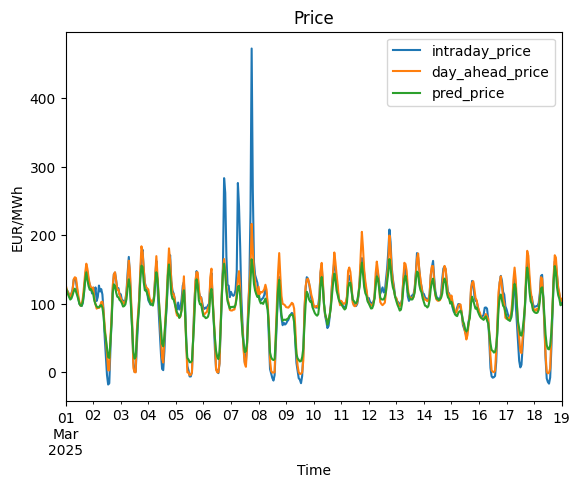

In [127]:
# Plot the results

import matplotlib.pyplot as plt
from pandas import RangeIndex

if type(test_df.index) is RangeIndex:
    test_df = test_df.set_index("timestamp")
if type(pred_df.index) is RangeIndex:
    pred_df = pred_df.set_index("timestamp")

# Put everything in one data frame
pdata = pd.DataFrame(
    {
        "intraday_price": test_df["idc_av_price_eurmwh"],  # type: ignore
        "day_ahead_price": test_df["daa_price_eurmwh"],  # type: ignore
        "pred_price": pred_df["predictions"],
    },
    index=test_df.index,  # type: ignore
)

plt.figure(figsize=(16, 9))
timeframe = (pdata.index >= "2025-03-01") & (pdata.index <= "2025-03-19")
pdata.loc[timeframe].plot(title="Price", xlabel="Time", ylabel="EUR/MWh")

# Print the average deviation
daa_diff = pdata["intraday_price"] - pdata["day_ahead_price"]
daa_dev_mean = daa_diff.abs().mean()
daa_dev_std = daa_diff.abs().std()
print(f" Day-ahead: Ø {daa_dev_mean:.2f} EUR  (σ = {daa_dev_std:.2f} EUR)")
pred_diff = pdata["intraday_price"] - pdata["pred_price"]
pred_dev_mean = pred_diff.abs().mean()
pred_dev_std = pred_diff.abs().std()
print(f" Predicted: Ø {pred_dev_mean:.2f} EUR  (σ = {pred_dev_std:.2f} EUR)")

# Find best blend factor
best_im = float("inf")
best_blend_fac = 0
for blend_fac in [v / 100 for v in range(1, 51)]:
    blend_price = (1 - blend_fac) * pdata["day_ahead_price"] + blend_fac * pdata[
        "pred_price"
    ]
    blend_diff = pdata["intraday_price"] - blend_price
    blend_dev_mean = blend_diff.abs().mean()
    blend_dev_std = blend_diff.abs().std()
    im = blend_dev_mean - daa_dev_mean
    if im < best_im:
        best_im = im
        best_blend_fac = blend_fac

# Print blended price
blend_fac = best_blend_fac
blend_price = (1 - blend_fac) * pdata["day_ahead_price"] + blend_fac * pdata[
    "pred_price"
]
blend_diff = pdata["intraday_price"] - blend_price
blend_dev_mean = blend_diff.abs().mean()
blend_dev_std = blend_diff.abs().std()
print(
    f"   Blended: Ø {blend_dev_mean:.2f} EUR  (σ = {blend_dev_std:.2f} EUR) with 𝜸 = {blend_fac}"
)
im = blend_dev_mean - daa_dev_mean
print(
    f"               {abs(im):.2f} EUR {'better' if im < 0 else 'worse'} than day-ahead"
)
